<a href="https://colab.research.google.com/github/kayla-jackson/spatial-modeling/blob/test-exploratory-sims/notebooks/spatially_correlated_p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
!pip install esda

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from esda.moran import Moran
import scipy.sparse as sp
import libpysal

In [189]:
# Static variables

GRID_SIZE = 10 # dimensions of spatial grid
NUM_SAMPLES = 1000

In [190]:
# Helper functions to generate a sample from MVN(0, sigma)

def adjacency_matrix(A):
    '''Returns the adjacency matrix W from A, a NumPy array'''
    rows, cols = len(A), len(A[0])
    locs = rows * cols # number of spatial locations on the grid
    W = np.zeros((locs, locs), dtype=int)

    # Iterate through each element in A to determine number of neighbors
    for r in range(rows):
        for c in range(cols):
            for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
                if 0 <= r + dr < rows and 0 <= c + dc < cols:
                    W[r * cols + c][(r + dr) * cols + c + dc] = 1

    return W

def sum_adjacency_matrix(W):
    '''Outputs matrix D with same dimensions as W;
    Sums the number of neighbors of the original points'''
    return np.diag(np.sum(W, axis=1))

def compute_sigma(A, alpha, tau):
    '''Outputs the covariance matrix termed sigma from original matrix A'''
    W = adjacency_matrix(A)
    D = sum_adjacency_matrix(W)

    Q = tau * (D - alpha * W) # the formula
    return np.linalg.inv(Q)

In [191]:
# Testing the functions

A = np.array([[1,2,3],[4,5,6],[7,8,9]])
W = adjacency_matrix(A)
D = sum_adjacency_matrix(W)
sigma = compute_sigma(A, 0.99, 1)

print(f'W: {W}')
print(f'D: {D}')
print(f'Sigma: {sigma}')

W: [[0 1 0 1 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0]
 [0 1 0 0 0 1 0 0 0]
 [1 0 0 0 1 0 1 0 0]
 [0 1 0 1 0 1 0 1 0]
 [0 0 1 0 1 0 0 0 1]
 [0 0 0 1 0 0 0 1 0]
 [0 0 0 0 1 0 1 0 1]
 [0 0 0 0 0 1 0 1 0]]
D: [[2 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 2]]
Sigma: [[4.72557687 4.26825946 4.10427136 4.26825946 4.10427136 4.02319782
  4.10427136 4.02319782 3.98296585]
 [4.26825946 4.51847503 4.26825946 4.10427136 4.14572864 4.10427136
  4.02319782 4.02340102 4.02319782]
 [4.10427136 4.26825946 4.72557687 4.02319782 4.10427136 4.26825946
  3.98296585 4.02319782 4.10427136]
 [4.26825946 4.10427136 4.02319782 4.51847503 4.14572864 4.02340102
  4.26825946 4.10427136 4.02319782]
 [4.10427136 4.14572864 4.10427136 4.14572864 4.35427136 4.14572864
  4.10427136 4.14572864 4.10427136]
 [4.02319782 4.10427136 4.26825946 4.02340102 4.14572864 4.51847503
  4.02319782 4.1042

In [192]:
# With the full 10x10 grid:

A = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
W = adjacency_matrix(A)
D = sum_adjacency_matrix(W)
sigma = compute_sigma(A, 0.99, 1)

print(f'W: {W}')
print(f'D: {D}')
print(f'Sigma: {sigma}')

W: [[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]
D: [[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]
Sigma: [[1.44637106 0.95593036 0.68112832 ... 0.14572908 0.1416529  0.14023637]
 [0.95593036 1.16191315 0.77788798 ... 0.14658889 0.14288171 0.1416529 ]
 [0.68112832 0.77788798 1.04330611 ... 0.14958705 0.14658889 0.14572908]
 ...
 [0.14572908 0.14658889 0.14958705 ... 1.04330611 0.77788798 0.68112832]
 [0.1416529  0.14288171 0.14658889 ... 0.77788798 1.16191315 0.95593036]
 [0.14023637 0.1416529  0.14572908 ... 0.68112832 0.95593036 1.44637106]]


In [193]:
# Generating the sample

def MVN_sample(sigma, num_samples):
    '''Returns a sample from a multivariate normal distribution
    where sigma is a covariance matrix'''
    zero_vector = np.zeros(len(sigma))
    samples = np.random.multivariate_normal(zero_vector, sigma, num_samples)
    print(samples)
    return samples

def inverse_logit(M):
    '''Transforms a matrix of values into the range (0,1)'''
    return 1 / (1 + np.exp(-M))

In [194]:
# Testing the above functions

samples = MVN_sample(sigma, NUM_SAMPLES)
transformed_samples = inverse_logit(samples)
print(samples)
print(transformed_samples)

[[-0.88208823 -1.14713655 -2.09201381 ... -0.78108322 -0.01382699
  -0.14642231]
 [-0.3389967  -0.67265191 -0.38713503 ... -0.16130503  0.06125095
  -0.43385162]
 [-1.48953799 -1.54634254 -1.72149687 ...  0.24483668 -0.95847744
  -0.74250243]
 ...
 [ 0.14144333 -0.40984147 -0.37476368 ...  0.51174392  1.79628785
   0.33586078]
 [ 1.56773868 -0.18668021  0.00906524 ...  0.78022752  1.33393453
   1.14713769]
 [-2.07252693 -2.31775373 -1.36727101 ... -0.8983901  -1.07969038
  -0.00869314]]
[[-0.88208823 -1.14713655 -2.09201381 ... -0.78108322 -0.01382699
  -0.14642231]
 [-0.3389967  -0.67265191 -0.38713503 ... -0.16130503  0.06125095
  -0.43385162]
 [-1.48953799 -1.54634254 -1.72149687 ...  0.24483668 -0.95847744
  -0.74250243]
 ...
 [ 0.14144333 -0.40984147 -0.37476368 ...  0.51174392  1.79628785
   0.33586078]
 [ 1.56773868 -0.18668021  0.00906524 ...  0.78022752  1.33393453
   1.14713769]
 [-2.07252693 -2.31775373 -1.36727101 ... -0.8983901  -1.07969038
  -0.00869314]]
[[0.29274523 0.2

In [195]:
# Computing Moran's I for the 1000 samples

def moran_I(samples, adj_matrix):
    '''Returns array of Moran's I values for each sample in samples;
    adj_matrix is spatial weights matrix'''

    moran_values = []

    # Compute Moran's I for each sample
    for sample in samples:
        moran_I = Moran(sample, adj_matrix).I
        moran_values.append(moran_I)

    return moran_values

In [196]:
# Create sparse array from adjacency matrix
sparse_W = sp.csr_matrix(W)

# Create a spatial weights matrix from the sparse matrix
W = libpysal.weights.WSP(sparse_W).to_W()

moran_values = moran_I(transformed_samples, W)
print(moran_values)

[0.38007614757608993, 0.35795710208448467, 0.40443574698469287, 0.40007982399036424, 0.5346487590294566, 0.4521157742585422, 0.4136062329187288, 0.5374028356479147, 0.3485333249254424, 0.39705742633614227, 0.4866992696748591, 0.5428269868186155, 0.5358182177798523, 0.409274276141456, 0.38021326015555706, 0.5518358145074886, 0.22418360032885895, 0.5665781089792572, 0.66465989708977, 0.3052293965511014, 0.5422985017192877, 0.43574891407662525, 0.6635209549232317, 0.3658081116596735, 0.3830111368377001, 0.42353911479969114, 0.5091415192852784, 0.37386242015853566, 0.5491451386082722, 0.7178967666102679, 0.2020729390948076, 0.4479940384837561, 0.5303832494507932, 0.2649870546186577, 0.3952448360942177, 0.6040913252793525, 0.4770918305609656, 0.4202398939849554, 0.6348782045138881, 0.534998420083273, 0.4185204858232825, 0.5855433768303249, 0.35578329071935705, 0.47821072394402714, 0.4689155227820193, 0.47179498760842603, 0.36457114651081, 0.6237858981860509, 0.275952428737691, 0.58928340489

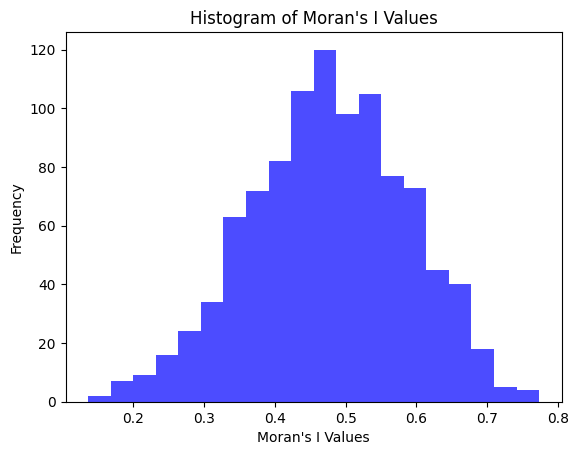

In [197]:
plt.hist(moran_values, bins=20, color='blue', alpha=0.7)
plt.xlabel("Moran's I Values")
plt.ylabel("Frequency")
plt.title("Histogram of Moran's I Values")
plt.show()